In [95]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [96]:
df = yf.download('AAPL', '2018-01-01', '2025-01-01')
df.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1761 non-null   float64
 1   (High, AAPL)    1761 non-null   float64
 2   (Low, AAPL)     1761 non-null   float64
 3   (Open, AAPL)    1761 non-null   float64
 4   (Volume, AAPL)  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB


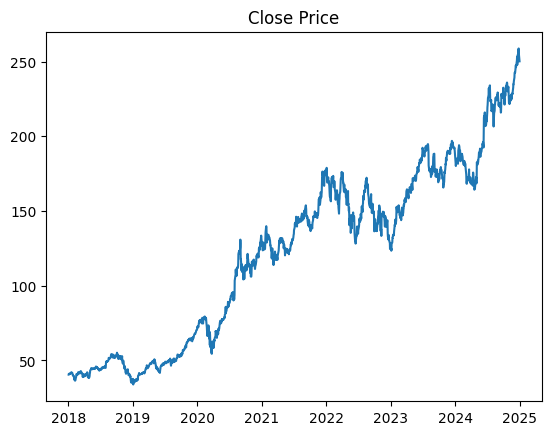

In [97]:
plt.title("Close Price")
plt.plot(df.Close)

Text(0.5, 1.0, 'Covid Era')

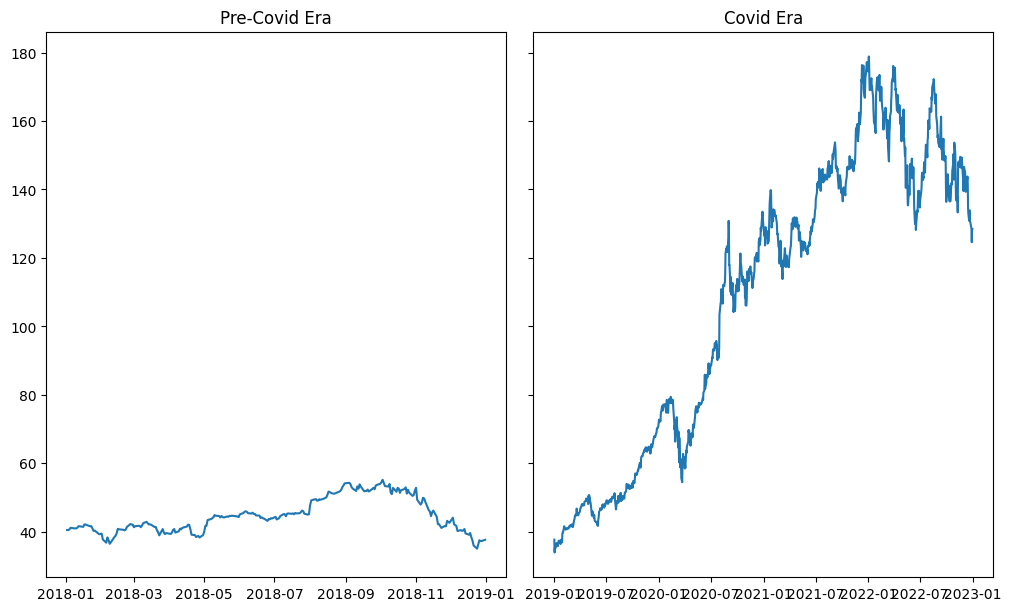

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),  layout = 'constrained', sharey = True)

ax[0].plot(df.loc['2018' : '2018', 'Close'])
ax[0].set_title("Pre-Covid Era")

ax[1].plot(df.loc['2019' : '2022', 'Close'])
ax[1].set_title("Covid Era")


In [99]:
print(df.describe())

Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1761.000000  1761.000000  1761.000000  1761.000000  1.761000e+03
mean     122.267031   123.479697   120.916910   122.144877  1.001437e+08
std       59.320514    59.791817    58.756641    59.248570  5.521978e+07
min       33.915253    34.757230    33.869933    34.342203  2.323470e+07
25%       54.279190    54.983889    53.891753    54.464935  6.304790e+07
50%      131.876678   133.369316   130.507723   132.341278  8.671200e+07
75%      169.228806   170.791455   167.787743   169.040908  1.214346e+08
max      258.735504   259.814335   257.347047   257.906429  4.265100e+08


In [100]:
df.reset_index(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1761 non-null   datetime64[ns]
 1   (Close, AAPL)   1761 non-null   float64       
 2   (High, AAPL)    1761 non-null   float64       
 3   (Low, AAPL)     1761 non-null   float64       
 4   (Open, AAPL)    1761 non-null   float64       
 5   (Volume, AAPL)  1761 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.7 KB
None


In [101]:
df['ma5'] = df.Close.rolling(window=5).mean()
df['ma10'] = df.Close.rolling(window=10).mean()
df['close_shifted'] = df.Close.shift(1)
df.dropna(inplace=True)
df


Price,Date,Close,High,Low,Open,Volume,ma5,ma10,close_shifted
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,
9,2018-01-16,41.403370,42.155346,41.391620,41.805205,118263600,41.226176,40.983900,41.614849
10,2018-01-17,42.087189,42.122436,41.140169,41.393957,137547200,41.450359,41.144634,41.403370
11,2018-01-18,42.124779,42.322175,41.887437,42.150628,124773600,41.683940,41.309833,42.087189
12,2018-01-19,41.936794,42.199985,41.690051,41.972042,129700400,41.833396,41.437434,42.124779
13,2018-01-22,41.593712,41.777006,41.499716,41.664210,108434400,41.829169,41.484433,41.936794
...,...,...,...,...,...,...,...,...,...
1756,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,252.881967,251.014017,254.989655
1757,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,255.073553,252.265639,257.916443
1758,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,256.232281,253.027800,258.735504


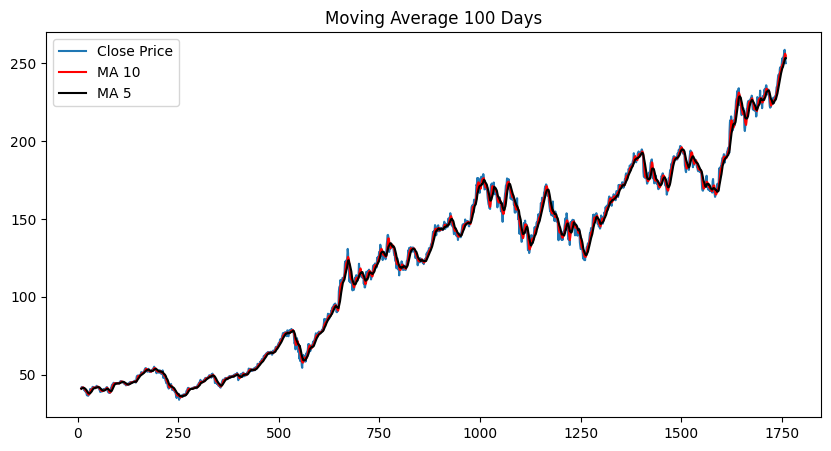

In [102]:
plt.figure(figsize=(10,5))
plt.title("Moving Average 100 Days")
plt.plot(df.Close, label="Close Price")
plt.plot(df.ma5, color='red', label="MA 10")
plt.plot(df.ma10, color='black', label="MA 5")

plt.legend()
plt.show()

In [103]:
def calculate_rsi(df, window=14):
    delta = df.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [104]:
df['rsi'] = calculate_rsi(df.Close).dropna()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['high_low_ratio'] = df['High'] / df['Low']
df = df.iloc[14:].reset_index(drop=True)
df

Price,Date,Close,High,Low,Open,Volume,ma5,ma10,close_shifted,rsi,day_of_week,month,high_low_ratio
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
0,2018-02-05,36.774010,38.510606,36.658862,37.387341,290954000,38.499794,39.502505,37.716335,15.243291,0,2,1.050513
1,2018-02-06,38.310852,38.472998,36.188869,36.383913,272975200,38.314620,39.173280,36.774010,24.866940,1,2,1.063117
2,2018-02-07,37.490723,38.397794,37.380279,38.324947,206434400,37.943798,38.828310,38.310852,22.067937,2,2,1.027221
3,2018-02-08,36.459110,37.833819,36.430912,37.666972,217562000,37.350206,38.453262,37.490723,20.030797,3,2,1.038509
4,2018-02-09,36.905052,37.254258,35.449237,37.060781,282690400,37.187949,38.113408,36.459110,24.633172,4,2,1.050918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,252.881967,251.014017,254.989655,76.180657,1,12,1.011438
1734,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,255.073553,252.265639,257.916443,76.812079,3,12,1.009587
1735,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,256.232281,253.027800,258.735504,69.300685,4,12,1.022287


In [105]:
features = ['Close','ma5', 'close_shifted', 'day_of_week', 'month', 'high_low_ratio', 'rsi']
df = df.set_index(df['Date'])

## LSTM

In [ ]:
def create_sequences(scaled_data, sequence_length, target_col=0):
    """
    scaled_data : Données normalisées (numpy array 2D)
    sequence_length : Longueur des séquences temporelles
    target_col : Index de la colonne cible (0 par défaut)
    """
    x_data = []
    y_data = []
    
    for i in range(sequence_length, len(scaled_data)):
        x_data.append(scaled_data[i-sequence_length:i, :])  # Toutes les features
        y_data.append(scaled_data[i, target_col])  # Uniquement la target

    return np.array(x_data), np.array(y_data)

# Application
sequence_length = 60
scaler = MinMaxScaler()
full_data = scaler.fit_transform(df[features])

train_size = int(len(full_data) * 0.8)
train_data = full_data[:train_size]
test_data = full_data[train_size:]

x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

train_data.shape, test_data.shape

((1390, 7), (348, 7))

In [ ]:
steps_ahead = 1
n_epochs = 50
num_hidden_layers = 1
num_neurons = 50
batch_size = 32
window_size = train_data.shape[0]


np.random.seed(42)
np.random.seed(12345)
tf.random.set_seed(1234)
model =  Sequential()

if num_hidden_layers == 1:
    model.add(LSTM(num_neurons, activation='relu', input_shape = (window_size, len(features))))
    
else:
    for num in range(num_hidden_layers-1):
        model.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, len(features)), return_sequences=True))        
    model.add(LSTM(num_neurons))
        
model.add(Dense(steps_ahead))
model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
#prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                            restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
            validation_data=(x_test, y_test), verbose=1, shuffle=False)
model.evaluate(x_test, y_test)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0135 - val_loss: 0.0342
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0401 - val_loss: 0.0036
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0315 - val_loss: 0.0027
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0080 - val_loss: 7.2615e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.4194e-04 - val_loss: 9.7656e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 2.9169e-04 - val_loss: 8.0055e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.6446e-04 - val_loss: 7.5443e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.0053e-04 - val_loss: 7.7776e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.0532e-04 - val_loss: 7.8734e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.7773e-04 - val_loss: 7.7953e-04
Epoch 12/50

0.0007261469145305455

In [ ]:
test_loss = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.7412e-04
Test Loss: 0.0007261469145305455


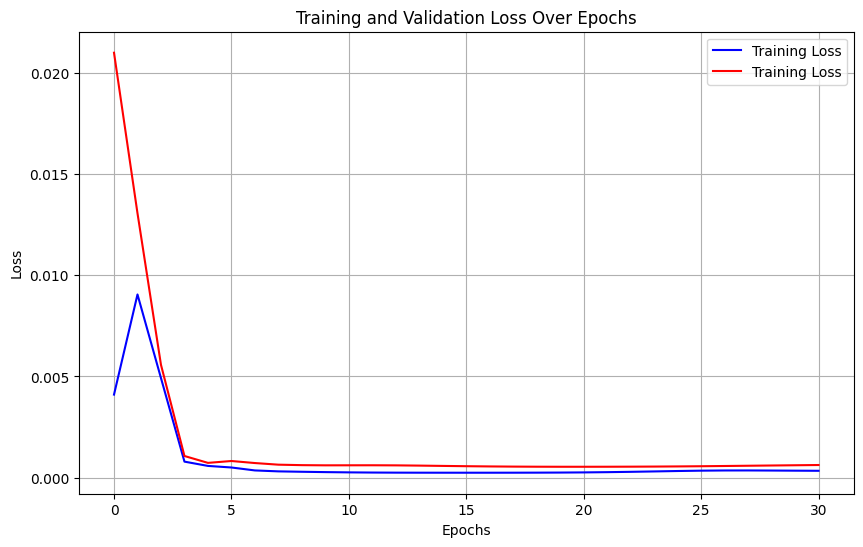

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Training Loss', color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
predictions = model.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
predictions = model.predict(x_test)

# Inverser la normalisation des prédictions
predicted_values = np.zeros(shape=(len(predictions), len(features)))
predicted_values[:, 0] = predictions.flatten()
predicted_values = scaler.inverse_transform(predicted_values)
predicted_close = predicted_values[:, 0]

# Inverser la normalisation des valeurs réelles
actual_values = np.zeros(shape=(len(y_test), len(features)))
actual_values[:, 0] = y_test.flatten()
actual_values = scaler.inverse_transform(actual_values)
actual_close = actual_values[:, 0]

results = pd.DataFrame({
    'Date': df['Date'].iloc[-len(y_test):].values,  # Dates correspondantes
    'Valeurs Réelles': actual_close,
    'Prédictions': predicted_close
})

print("Valeurs Réelles vs Prédictions :")
print(results)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Valeurs Réelles vs Prédictions :
          Date  Valeurs Réelles  Prédictions
0   2023-11-08       181.559296   178.065845
1   2023-11-09       181.082809   180.916672
2   2023-11-10       185.287552   183.252725
3   2023-11-13       183.697098   185.704543
4   2023-11-14       186.321350   185.790788
..         ...              ...          ...
283 2024-12-24       257.916443   245.838288
284 2024-12-26       258.735504   248.011634
285 2024-12-27       255.309296   250.789470
286 2024-12-30       251.923019   249.666495
287 2024-12-31       250.144974   246.178014

[288 rows x 3 columns]


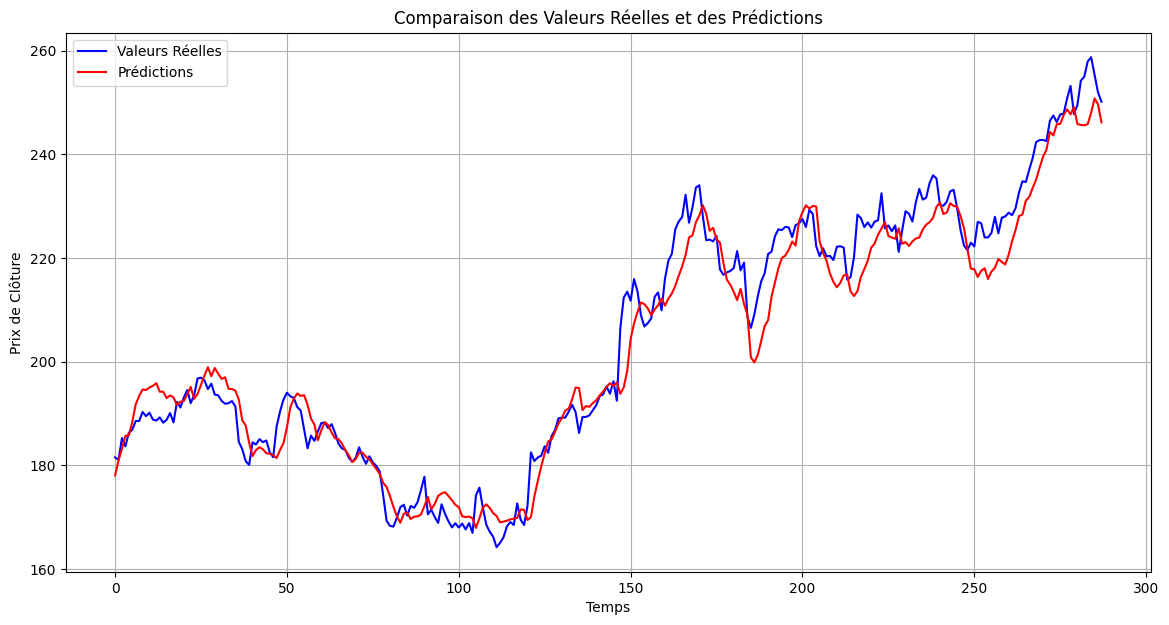

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(actual_close, color='blue', label='Valeurs Réelles')
plt.plot(predicted_close, color='red', label='Prédictions')
plt.title('Comparaison des Valeurs Réelles et des Prédictions')
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.grid(True)
plt.show()